# Multi Layer Perceptron for Name-Like Workd Generator

<img src="4d_mlp.png">


This is a Python script that implements a multi layered perceptron (MLP) model to generate new name-like words. It refers [A Neural Probabilistic Language Model (Yoshua Bengio, et. al. 2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) to simultaneously learns a distributed representation of the characters and a probability function for character sequences.

## Data Loading
The script starts by loading a dataset of names from a file named "names.txt". The dataset is split into individual names.

In [1]:
# load dataset
from pathlib import Path

names = Path("data/names.txt").read_text().split("\n")

special = "."

In [2]:
chars = sorted(list(set(special.join(names))))

In [3]:
stoi = {s:i for i,s in enumerate(chars)}
itos = {i:s for i,s in enumerate(chars)}

In [4]:
# major parameters
block_size = 3
embedding_dimension = 2
size_of_first_layer = 100 # updated from 100 to 300
size_of_output_layer= len(chars) # 27
mini_batch_size = 64

In [5]:
# generating dataset for blocksizes of x
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def generate_dataset(block_size, data):
    """generates the dataset for n-gram models for default n=block_size"""
    X, Y = [], []
    import random
    random.seed(42)
    random.shuffle(data)
    for name in names:
        word = name + special
        context = [0] * block_size
        for ch in word:
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X, Y = torch.tensor(X), torch.tensor(Y)
    return X,Y

def split_dataset(X, Y, splits=(0.8, 0.9)):
    """splits the dataset into train, dev and test sets with a default split of 0.8, 0.9"""
    n1, n2 = (int(s*len(X)) for s in splits)
    print(n1, n2)
    x_train, y_train = X[:n1], Y[:n1]
    x_dev, y_dev = X[n1:n2], Y[n1:n2]
    x_test, y_test = X[n2:], Y[n2:]

    return x_train, y_train, x_dev, y_dev, x_test, y_test
    

In [16]:
X, Y = generate_dataset(block_size, names)
x_train, y_train, x_dev, y_dev, x_test, y_test = split_dataset(X, Y)

182516 205331


## Building the Embedding Matrix

In our project, we define an embedding matrix comprising free parameters that represent vectors for each word in the vocabulary. In this context, our vocabulary consists of characters, resulting in a vocabulary size of 26 + 1 (including a special character). Initially, we set the dimension of each character embedding to 2 (although this dimension can be adjusted for improved for a better model).

In [17]:
g = torch.Generator().manual_seed(142887)

C = torch.randn((len(chars), embedding_dimension), generator=g)
emb = C[x_train]

## Defining the model

In [18]:
# layer 1: takes embedding of input as the input to this layer => 6 x size of the layer
W1 = torch.randn((block_size * embedding_dimension, size_of_first_layer), generator=g) # 6x100
b1 = torch.randn(size_of_first_layer, generator=g)

# layer 2: final layer results in a probability for each character of the vocab
W2 = torch.randn((size_of_first_layer, size_of_output_layer), generator=g) # 100x27
b2 = torch.randn(size_of_output_layer, generator=g)

In [19]:
# parameters
params = [C, W1, b1, W2, b2]
print(f"Number of parameters: {sum([p.nelement() for p in params])}")

# adding grads
for param in params:
    param.requires_grad = True

Number of parameters: 3481


## Finding the learning rate
Analysing the learning curve to find a suitable learning rate for the model

In [10]:
# find learning rate between 0.1 and 1
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [11]:
lri = []
lossi = []
for i in range(1000):
    # forward pass
    # using minibatches for faster learning
    ix = torch.randint(0, x_train.shape[0], (mini_batch_size,))

    emb = C[x_train[ix]]
    h = torch.tanh(emb.view(-1, embedding_dimension*block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[ix])

    for p in params:
        p.grad = None

    loss.backward()
    lr = lrs[i]
    for p in params:
        p.data += -(lr)*p.grad
    lri.append(lr)
    lossi.append(loss.item())

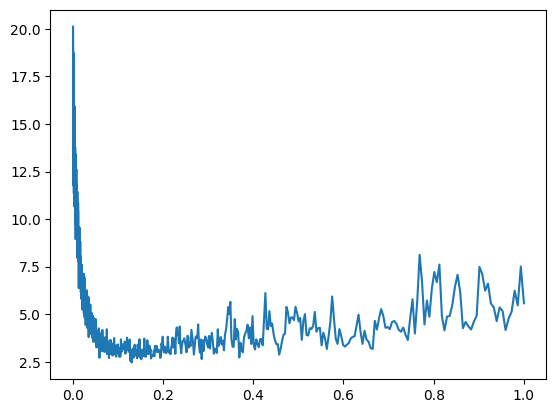

In [12]:
plt.plot(lri, lossi)

Seems like, 0.1 is a reasonable learning rate.

## Learning

In [20]:
epochi = []
lossi = []

Learning started with,
block size 3
embedding dimensions 2
size of first layer 100
size of output layer 27
Epoch 0: 16.290098190307617
Epoch 10000: 2.4869120121002197
Epoch 20000: 2.377363443374634
Epoch 30000: 2.7068192958831787
Epoch 40000: 2.4677484035491943
Epoch 50000: 2.508709669113159
Epoch 60000: 2.469247341156006
Epoch 70000: 2.070878267288208
Epoch 80000: 2.3165860176086426
Epoch 90000: 2.5133776664733887


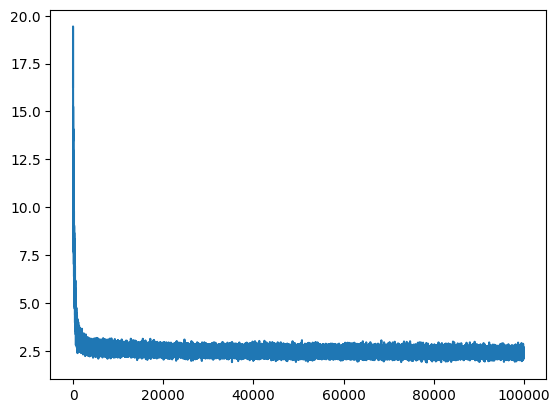

In [21]:
print(f"""Learning started with,
block size {block_size}
embedding dimensions {embedding_dimension}
size of first layer {size_of_first_layer}
size of output layer {size_of_output_layer}
===========""")

epochs = 100000
learning_rate = 0.1

for epoch in range(epochs):
    
    ix = torch.randint(0, x_train.shape[0], (mini_batch_size,))

    emb = C[x_train[ix]]
    h = torch.tanh(emb.view(-1, embedding_dimension*block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[ix])

    for p in params:
        p.grad = None

    loss.backward()
    
    lr = 0.01
    for p in params:
        p.data += -(lr)*p.grad
    epochi.append(epoch)
    lossi.append(loss.item())

    if not epoch % 10000:
        print(f"Epoch {epoch}: {loss.item()}")
plt.plot(epochi, lossi)

## Testing for overfitting

In [22]:
# loss on all of trainset
emb = C[x_train]
h = torch.tanh(emb.view(-1, embedding_dimension*block_size)@W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
loss.item()

2.395190715789795

In [23]:
# loss on all of devset
emb = C[x_dev]
h = torch.tanh(emb.view(-1, embedding_dimension*block_size)@W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_dev)
loss.item()

2.3918657302856445

## Visualizing the learned embeddings (2D embedding)
For starters we chose the embedding dimensions of the characters as 2. The plot below represents how the embeddings have been learned. 

A few findings:
1. The vowels (a, e, i, o, u) seems to be clustered together
2. The character q is far separated from the rest of the plot, probably due to the rarity of its occurence in names.

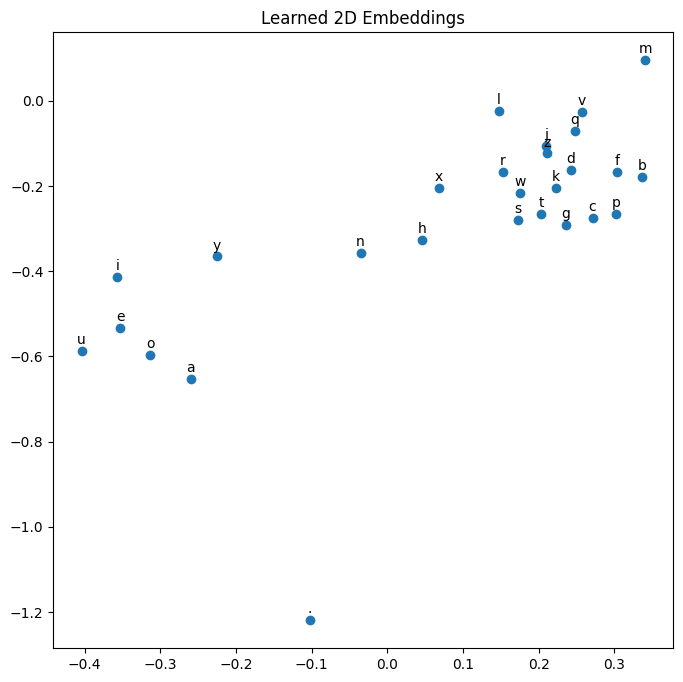

In [24]:
cx = C[:, 0].detach().numpy()
cy = C[:, 1].detach().numpy()

# Plot the learned embeddings
plt.figure(figsize=(8, 8))
plt.scatter(cx, cy)
plt.title('Learned 2D Embeddings')
for i, txt in enumerate(range(len(C))):
    plt.annotate(itos[txt], (cx[i], cy[i]), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()

## Visualizing the learned embeddings (in 4 dimensions)
Increasing the complexity of the models allows us to tweak a few more major params: the embedding dimensions of the characters being one of these. Following is the representation of the learned embeddings in a 4 dimensional space. 

A few findings:
1. The vowels (a, e, i, o, u) seems to be clustered together
2. The characters w, z are far separated from the rest of the plot, probably due to the rarity of their occurences in names.

182516 205331
Number of parameters: 12135
Learning started with,
block size 3
embedding dimensions 4
size of first layer 300
size of output layer 27
Epoch 0: 24.602731704711914
Epoch 10000: 2.6150896549224854
Epoch 20000: 2.4709441661834717
Epoch 30000: 2.3397696018218994
Epoch 40000: 2.1721861362457275
Epoch 50000: 2.344306707382202
Epoch 60000: 2.201780319213867
Epoch 70000: 2.125873327255249
Epoch 80000: 2.2958719730377197
Epoch 90000: 2.5556800365448
Epoch 100000: 2.128875255584717
Epoch 110000: 2.3863983154296875
Epoch 120000: 2.1679012775421143
Epoch 130000: 2.3279192447662354
Epoch 140000: 2.37538480758667
Epoch 150000: 2.219709873199463
Epoch 160000: 1.8799446821212769
Epoch 170000: 2.1794955730438232
Epoch 180000: 2.034022331237793
Epoch 190000: 2.052391767501831
Epoch 200000: 2.3194820880889893
Epoch 210000: 2.271955966949463
Epoch 220000: 2.0129992961883545
Epoch 230000: 2.2592735290527344
Epoch 240000: 2.0261075496673584
Epoch 250000: 1.9242830276489258
Epoch 260000: 2.0258

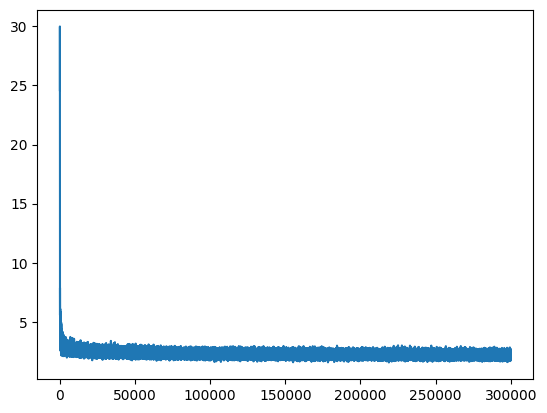

In [38]:
# major params
block_size = 3
embedding_dimension = 4
size_of_first_layer = 300
size_of_output_layer= len(chars) # 27
mini_batch_size = 64

# dataset
X, Y = generate_dataset(block_size, names)
x_train, y_train, x_dev, y_dev, x_test, y_test = split_dataset(X, Y)

# embeddings
g = torch.Generator().manual_seed(142887)

C = torch.randn((len(chars), embedding_dimension), generator=g)
emb = C[x_train]

# defining the model
# layer 1: takes embedding of input as the input to this layer => 6 x size of the layer
W1 = torch.randn((block_size * embedding_dimension, size_of_first_layer), generator=g) # 6x100
b1 = torch.randn(size_of_first_layer, generator=g)

# layer 2: final layer results in a probability for each character of the vocab
W2 = torch.randn((size_of_first_layer, size_of_output_layer), generator=g) # 100x27
b2 = torch.randn(size_of_output_layer, generator=g)

params = [C, W1, b1, W2, b2]
print(f"Number of parameters: {sum([p.nelement() for p in params])}")

# adding grads
for param in params:
    param.requires_grad = True

epochi = []
lossi = []

# learning
print(f"""Learning started with,
block size {block_size}
embedding dimensions {embedding_dimension}
size of first layer {size_of_first_layer}
size of output layer {size_of_output_layer}
===========""")

epochs = 300000
learning_rate = 0.1

for epoch in range(epochs):
    
    ix = torch.randint(0, x_train.shape[0], (mini_batch_size,))

    emb = C[x_train[ix]]
    h = torch.tanh(emb.view(-1, embedding_dimension*block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y_train[ix])

    for p in params:
        p.grad = None

    loss.backward()
    
    for p in params:
        p.data += -(learning_rate)*p.grad
    epochi.append(epoch)
    lossi.append(loss.item())

    if not epoch % 10000:
        print(f"Epoch {epoch}: {loss.item()}")
plt.plot(epochi, lossi)

In [39]:
# loss on all of trainset
emb = C[x_train]
h = torch.tanh(emb.view(-1, embedding_dimension*block_size)@W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
loss.item()

2.1701931953430176

In [40]:
# loss on all of devset
emb = C[x_dev]
h = torch.tanh(emb.view(-1, embedding_dimension*block_size)@W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_dev)
loss.item()

2.216735363006592

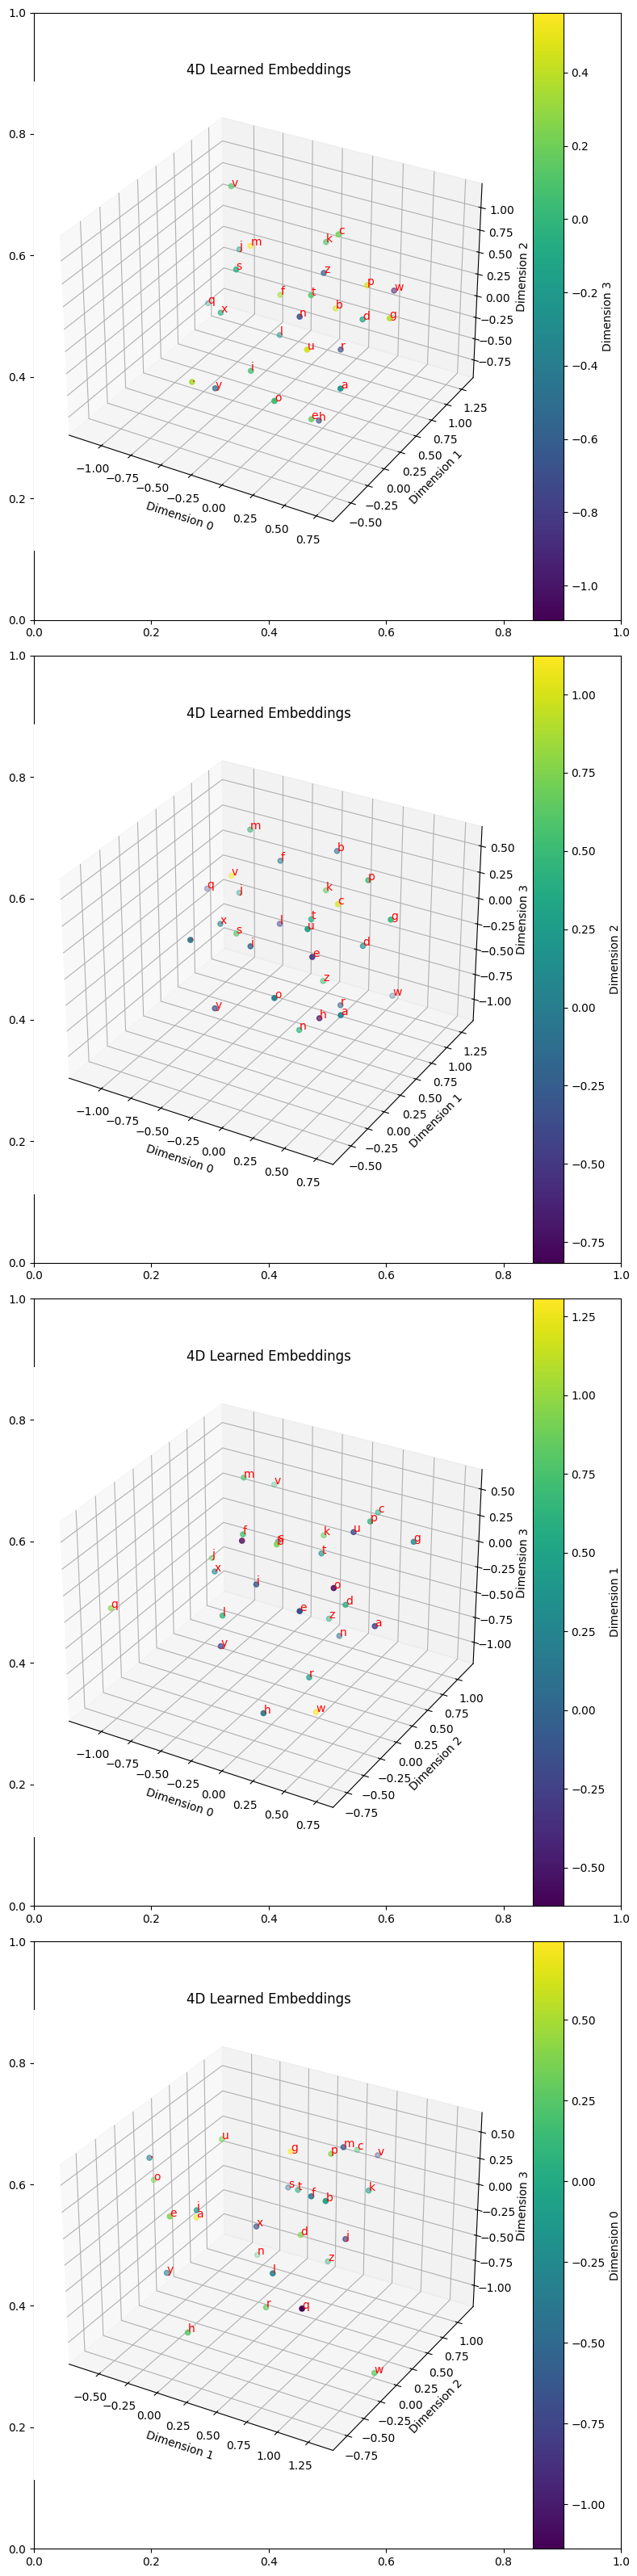

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations
import torch

# Assuming C is your 4D tensor
tensor = C.clone().detach().requires_grad_(True)

# Get all combinations of 3D projections
combinations_3d = list(combinations([0, 1, 2, 3], 3))

# Create subplots for each combination
fig, axes = plt.subplots(len(combinations_3d), 1, figsize=(8, 8 * len(combinations_3d)))

for i, combo in enumerate(combinations_3d):
    ax = fig.add_subplot(len(combinations_3d), 1, i + 1, projection='3d')
    x_combo = tensor[:, combo[0]].detach().numpy()
    y_combo = tensor[:, combo[1]].detach().numpy()
    z_combo = tensor[:, combo[2]].detach().numpy()
    
    
    
    # Get the dimension that is not in the current combination
    diff_label = list(set([0, 1, 2, 3]).difference(set(combo)))[0]
    w = tensor[:, diff_label].detach().numpy()
    scatter = ax.scatter(x_combo, y_combo, z_combo, c=w, cmap='viridis')
    
    plt.colorbar(scatter, label=f'Dimension {diff_label}')
    
    ax.set_title(f'4D Learned Embeddings')
    ax.set_xlabel(f'Dimension {combo[0]}')
    ax.set_ylabel(f'Dimension {combo[1]}')
    ax.set_zlabel(f'Dimension {combo[2]}')

    # Annotate points with their index
    for j, txt in enumerate(range(len(C))):
        ax.text(x_combo[j], y_combo[j], z_combo[j], itos[txt], color='red')
plt.tight_layout()
plt.show()


## Evaluating on test set

In [42]:
emb = C[x_test]
h = torch.tanh(emb.view(-1, embedding_dimension*block_size)@W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_test)
loss.item()

2.219430685043335

## Sampling from the model

In [43]:
g = torch.Generator().manual_seed(987092834)

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

zaedezel.
son.
arekminuont.
mallo.
avayley.
vla.
kya.
keann.
jenes.
tyrriona.
